config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


AssertionError: Please, be nice to Wikipedia and specify user agent - https://meta.wikimedia.org/wiki/User-Agent_policy. Current user_agent: 'en' is not sufficient. Use Wikipedia(user_agent='your-user-agent', language='en')

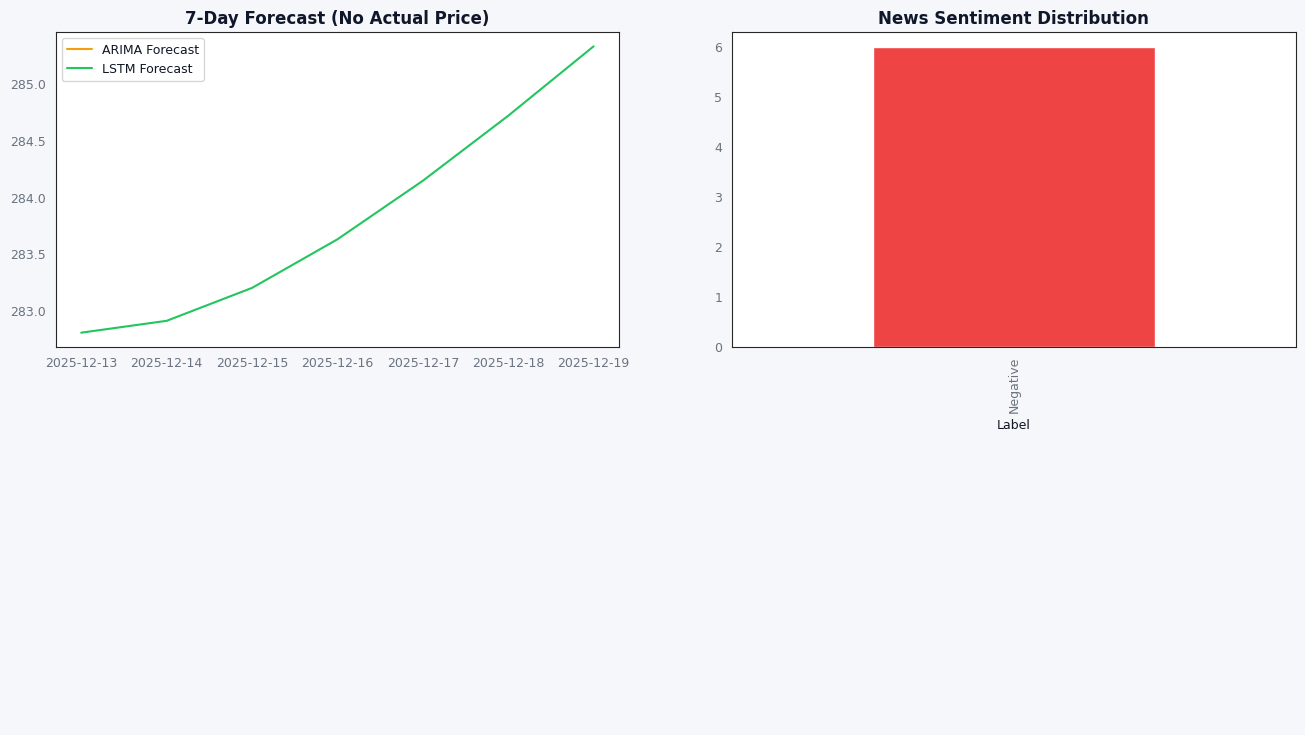

In [37]:
# ============================================================
# REAL-TIME INDUSTRY INSIGHT SYSTEM
# Modern SaaS Dashboard + Forecasting (ARIMA + LSTM)
# FULLY CORRECTED • SINGLE CELL • SAFE FALLBACKS
# ============================================================

import os, math, warnings, textwrap, requests
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.table as mtable
from PIL import Image

warnings.filterwarnings("ignore")

# ================= SAFE IMPORTS =================
try:
    import yfinance as yf
except:
    yf = None

try:
    import feedparser
except:
    feedparser = None

try:
    import wikipediaapi
except:
    wikipediaapi = None

try:
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    FINBERT_OK = True
except:
    FINBERT_OK = False

try:
    from statsmodels.tsa.arima.model import ARIMA
    ARIMA_OK = True
except:
    ARIMA_OK = False

try:
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    LSTM_OK = True
except:
    LSTM_OK = False

# ================= CONFIG =================
EXPORT_DIR = "exported"
os.makedirs(EXPORT_DIR, exist_ok=True)

COMPANIES = ["Apple", "Google", "Amazon", "Microsoft", "Tesla"]
SYMBOLS = {
    "Apple": "AAPL",
    "Google": "GOOGL",
    "Amazon": "AMZN",
    "Microsoft": "MSFT",
    "Tesla": "TSLA"
}

ALPHA_VANTAGE_API_KEY = "OPTIONAL"
SLACK_WEBHOOK_URL = "OPTIONAL"

# ================= THEME =================
BG = "#f5f7fa"
CARD = "#ffffff"
ACCENT = "#2563eb"
POS = "#16a34a"
NEG = "#ef4444"
MUTED = "#6b7280"
HEADER = "#020617"

# ================= WIKIPEDIA METADATA =================
def get_company_metadata(company):
    if wikipediaapi is None:
        return "Metadata unavailable (Wikipedia API missing)."
    wiki = wikipediaapi.Wikipedia("en")
    page = wiki.page(company)
    return page.summary[:500] if page.exists() else "No summary available."

# ================= NEWS FETCH =================
def get_news(company, n=6):
    if feedparser is None:
        return [f"{company} market sentiment remains mixed",
                f"Investors monitor {company} stock closely"]
    url = f"https://news.google.com/rss/search?q={company}+stock&hl=en-US&gl=US&ceid=US:en"
    feed = feedparser.parse(url)
    titles = [e.title for e in feed.entries[:n]]
    return titles if titles else [f"{company} news unavailable"]

# ================= SENTIMENT (FinBERT or Fallback) =================
if FINBERT_OK:
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    labels = ["Negative", "Neutral", "Positive"]

def sentiment_score(text):
    if FINBERT_OK:
        inputs = tokenizer(text[:512], return_tensors="pt", truncation=True)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)[0]
        idx = torch.argmax(probs).item()
        score = 1 if idx == 2 else -1 if idx == 0 else 0
        return labels[idx], score
    else:
        return "Neutral", 0

# ================= MARKET DATA =================
def get_stock(symbol, days=506):
    if yf is None:
        return pd.DataFrame()
    df = yf.download(symbol, period=f"{days}d", progress=False)
    return df[["Close"]].dropna()

# ================= ALPHA VANTAGE SMA =================
def get_sma(symbol):
    if ALPHA_VANTAGE_API_KEY == "OPTIONAL":
        return None
    try:
        url = f"https://www.alphavantage.co/query?function=SMA&symbol={symbol}&interval=daily&time_period=20&series_type=close&apikey={ALPHA_VANTAGE_API_KEY}"
        data = requests.get(url).json()
        return float(list(data["Technical Analysis: SMA"].values())[0]["SMA"])
    except:
        return None

# ================= FORECASTING =================
def arima_forecast(series, days=7):
    if not ARIMA_OK or len(series) < 50:
        return None
    model = ARIMA(series, order=(5,1,0))
    res = model.fit()
    idx = pd.date_range(series.index[-1] + timedelta(days=1), periods=days)
    return pd.Series(res.forecast(days), index=idx)

def lstm_forecast(series, days=7):
    if not LSTM_OK or len(series) < 60:
        return None
    scaler = MinMaxScaler()
    s = scaler.fit_transform(series.values.reshape(-1,1))
    lookback = 30
    X, y = [], []
    for i in range(lookback, len(s)):
        X.append(s[i-lookback:i])
        y.append(s[i])
    X, y = np.array(X), np.array(y)
    model = Sequential([
        LSTM(50, input_shape=(lookback,1)),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile("adam", "mse")
    model.fit(X, y, epochs=5, batch_size=8, verbose=0)
    seq = s[-lookback:]
    preds = []
    for _ in range(days):
        p = model.predict(seq.reshape(1,lookback,1), verbose=0)[0][0]
        preds.append(p)
        seq = np.vstack([seq[1:], [[p]]])
    preds = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
    idx = pd.date_range(series.index[-1] + timedelta(days=1), periods=days)
    return pd.Series(preds, index=idx)

# ================= DASHBOARD =================
def draw_dashboard(company):
    symbol = SYMBOLS[company]
    stock = get_stock(symbol)
    news = get_news(company)

    sentiments = [sentiment_score(n) for n in news]
    sent_df = pd.DataFrame(sentiments, columns=["Label", "Score"])

    ar_fc = arima_forecast(stock["Close"]) if not stock.empty else None
    ls_fc = lstm_forecast(stock["Close"]) if not stock.empty else None

    # Export CSV
    sent_df.to_csv(f"{EXPORT_DIR}/{company}_sentiment.csv", index=False)

    fig = plt.figure(figsize=(16,9), facecolor=BG)
    gs = fig.add_gridspec(2,2)

    # Price + Forecast (forecast only)
    ax1 = fig.add_subplot(gs[0,0])
    if ar_fc is not None:
        ax1.plot(ar_fc.index, ar_fc.values, label="ARIMA Forecast", color="#f59e0b")
    if ls_fc is not None:
        ax1.plot(ls_fc.index, ls_fc.values, label="LSTM Forecast", color="#22c55e")
    ax1.set_title("7-Day Forecast (No Actual Price)")
    ax1.legend()

    # Sentiment
    ax2 = fig.add_subplot(gs[0,1])
    sent_df["Label"].value_counts().plot(kind="bar", ax=ax2,
                                         color=[NEG, MUTED, POS])
    ax2.set_title("News Sentiment Distribution")

    # Metadata
    ax3 = fig.add_subplot(gs[1,:])
    ax3.axis("off")
    meta = get_company_metadata(company)
    ax3.text(0.01, 0.95,
             f"Company: {company} ({symbol})\n\n{meta}",
             va="top", fontsize=11)

    plt.tight_layout()
    plt.show()

    fig.savefig(f"{EXPORT_DIR}/{company}_dashboard.png", dpi=200)
    print(f"✅ Dashboard & CSV exported for {company}")

# ================= RUN =================
draw_dashboard("Apple")
